Dataset Shape: (100000, 13)
Columns: ['Timestamp', 'Machine_ID', 'Operation_Mode', 'Temperature_C', 'Vibration_Hz', 'Power_Consumption_kW', 'Network_Latency_ms', 'Packet_Loss_Perc', 'Quality_Control_Defect_Rate_Perc', 'Production_Speed_units_per_hr', 'Predictive_Maintenance_Score', 'Error_Rate_Perc', 'Efficiency_Status']

Efficiency_Status Distribution:
 Efficiency_Status
Low       77825
Medium    19189
High       2986
Name: count, dtype: int64

Operation_Mode Distribution:
 Operation_Mode
Active         70054
Idle           20057
Maintenance     9889
Name: count, dtype: int64

Encoded Efficiency Classes: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}

Correlations with Efficiency:
 Efficiency_Code                     1.000000
Production_Speed_units_per_hr       0.103402
Power_Consumption_kW                0.003622
Temperature_C                       0.002075
Network_Latency_ms                  0.001389
Vibration_Hz                        0.000558
Predictive_Maintenan

c:\Users\faheem\miniconda3\envs\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(



Cross-Validation Macro F1-Scores: [0.99661092 0.99468906 0.99429072 0.99822013 0.99407067]
Mean CV Macro F1-Score: 0.9955762973030249

Best Parameters (XGBoost): {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}

Test Set Classification Report:

              precision    recall  f1-score   support

        High       0.99      1.00      0.99       537
         Low       1.00      0.99      0.99     14009
      Medium       0.98      0.98      0.98      3454

    accuracy                           0.99     18000
   macro avg       0.99      0.99      0.99     18000
weighted avg       0.99      0.99      0.99     18000


Confusion Matrix (Test Set):
Labels: ['High', 'Low', 'Medium']
[[  535     0     2]
 [    0 13928    81]
 [    5    61  3388]]

Holdout Set Classification Report (Unbalanced):

              precision    recall  f1-score   support

        High       0.99      0.98      0.99       299
         Low       1.00      0.99      0.99      7782
   

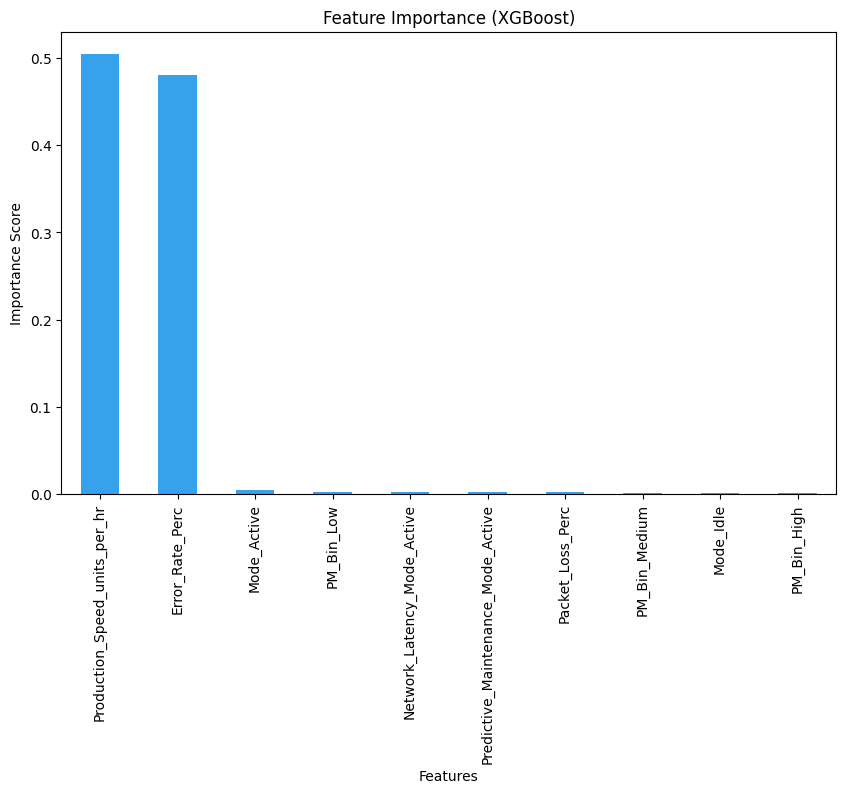


Random Forest - Holdout Set Classification Report (Unbalanced):

              precision    recall  f1-score   support

        High       1.00      0.99      1.00       299
         Low       1.00      1.00      1.00      7782
      Medium       1.00      1.00      1.00      1919

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


Models and preprocessors saved.


In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt

# Step 2: Load and Inspect Data
df = pd.read_csv(r'C:\MLOps Projects\Smart-Manufacturing-Machines-Efficiency-Prediction\artifacts\raw\raw.csv')

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nEfficiency_Status Distribution:\n", df['Efficiency_Status'].value_counts())
print("\nOperation_Mode Distribution:\n", df['Operation_Mode'].value_counts())

# Step 3: Check for Data Leakage
le = LabelEncoder()
df['Efficiency_Code'] = le.fit_transform(df['Efficiency_Status'])
print("\nEncoded Efficiency Classes:", dict(zip(le.classes_, le.transform(le.classes_))))

correlations = df.select_dtypes(include=[np.number]).corr()['Efficiency_Code'].sort_values(ascending=False)
print("\nCorrelations with Efficiency:\n", correlations)

# Step 4: Preprocessing
df = df.drop(['Timestamp', 'Machine_ID', 'Efficiency_Code'], axis=1)

# One-hot encode Operation_Mode
df = pd.get_dummies(df, columns=['Operation_Mode'], prefix='Mode')

# Label encode Efficiency_Status (High=0, Low=1, Medium=2)
df['Efficiency_Status'] = le.fit_transform(df['Efficiency_Status'])

# Feature Engineering: Interaction terms
df['Predictive_Maintenance_Mode_Active'] = df['Predictive_Maintenance_Score'] * df['Mode_Active']
df['Quality_Control_Mode_Active'] = df['Quality_Control_Defect_Rate_Perc'] * df['Mode_Active']
df['Network_Latency_Mode_Active'] = df['Network_Latency_ms'] * df['Mode_Active']

# Bin Predictive_Maintenance_Score
df['Predictive_Maintenance_Binned'] = pd.cut(df['Predictive_Maintenance_Score'], bins=3, labels=['Low', 'Medium', 'High'])
df = pd.get_dummies(df, columns=['Predictive_Maintenance_Binned'], prefix='PM_Bin')

# Split features and target
X = df.drop('Efficiency_Status', axis=1)
y = df['Efficiency_Status']

# Step 5: Split Data (Create a Holdout Set)
X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)  # 54% train, 18% val, 18% test, 10% holdout

# Step 6: Scale Numerical Features
scaler = StandardScaler()

# Store indices before scaling
X_train_index = X_train.index
X_val_index = X_val.index
X_test_index = X_test.index
X_holdout_index = X_holdout.index

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns, index=X_train_index)

X_val = scaler.transform(X_val)
X_val = pd.DataFrame(X_val, columns=X.columns, index=X_val_index)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns, index=X_test_index)

X_holdout = scaler.transform(X_holdout)
X_holdout = pd.DataFrame(X_holdout, columns=X.columns, index=X_holdout_index)

# Step 7: Feature Selection using Mutual Information
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()].tolist()
print("\nSelected Features:", selected_features)

X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)
X_holdout_selected = selector.transform(X_holdout)

# Step 8: Apply SMOTE to Training Data Only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)
print("\nBalanced Training Class Distribution:\n", pd.Series(y_train_balanced).value_counts())

# Step 9: Compute Sample Weights for Multi-Class
class_counts = pd.Series(y).value_counts().sort_index()  # High=0, Low=1, Medium=2
weights = {0: 10, 1: 1, 2: class_counts[1]/class_counts[2]}  # Adjusted High class weight
sample_weights = np.array([weights[label] for label in y_train_balanced])

# Step 10: Train XGBoost Model
model_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss'
)
model_xgb.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)

# Step 11: Evaluate on Validation Set
y_val_pred = model_xgb.predict(X_val_selected)
print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_val_pred, target_names=['High', 'Low', 'Medium']))

cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix (Validation Set):")
print("Labels: ['High', 'Low', 'Medium']")
print(cm)

# Step 12: Cross-Validation on Original Data
X_cv = selector.transform(scaler.transform(X))
cv_scores = cross_val_score(model_xgb, X_cv, y, cv=5, scoring='f1_macro')
print("\nCross-Validation Macro F1-Scores:", cv_scores)
print("Mean CV Macro F1-Score:", cv_scores.mean())

# Step 13: Hyperparameter Tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0]
}
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='f1_macro',
    random_state=42
)
random_search.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)
print("\nBest Parameters (XGBoost):", random_search.best_params_)

# Step 14: Train Final XGBoost Model
best_model_xgb = random_search.best_estimator_
best_model_xgb.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)

# Step 15: Evaluate on Test Set
y_test_pred = best_model_xgb.predict(X_test_selected)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_test_pred, target_names=['High', 'Low', 'Medium']))

cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Test Set):")
print("Labels: ['High', 'Low', 'Medium']")
print(cm_test)

# Step 16: Evaluate on Holdout Set (Unbalanced)
y_holdout_pred = best_model_xgb.predict(X_holdout_selected)
print("\nHoldout Set Classification Report (Unbalanced):\n")
print(classification_report(y_holdout, y_holdout_pred, target_names=['High', 'Low', 'Medium']))

cm_holdout = confusion_matrix(y_holdout, y_holdout_pred)
print("\nConfusion Matrix (Holdout Set - Unbalanced):")
print("Labels: ['High', 'Low', 'Medium']")
print(cm_holdout)

# Step 17: Feature Importance (XGBoost)
feature_importance_xgb = pd.Series(best_model_xgb.feature_importances_, index=selected_features).sort_values(ascending=False)
print("\nFeature Importance (XGBoost):\n", feature_importance_xgb)

plt.figure(figsize=(10, 6))
feature_importance_xgb.plot(kind='bar', color='#36A2EB')
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

# Step 18: Train Random Forest for Comparison
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)

# Evaluate Random Forest on Holdout Set
y_holdout_pred_rf = model_rf.predict(X_holdout_selected)
print("\nRandom Forest - Holdout Set Classification Report (Unbalanced):\n")
print(classification_report(y_holdout, y_holdout_pred_rf, target_names=['High', 'Low', 'Medium']))

# Step 19: Save Models (Optional)
import joblib
joblib.dump(best_model_xgb, 'xgboost_model.pkl')
joblib.dump(model_rf, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("\nModels and preprocessors saved.")